# Classification of Loan Data

This notebook explores loan data from LendingClub.com. The dataset contains information about loan recipients, including whether the loan has been fully paid or not. Here we'll explore the data and try to predict if a loan is likely to be paid or not.

In [1]:
# Import common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
loans = pd.read_csv('loan_data.csv')

In [3]:
loans.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


Here's a description of the variables:
+ credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
+ purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
+ int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
+ installment: The monthly installments owed by the borrower if the loan is funded.
+ log.annual.inc: The natural log of the self-reported annual income of the borrower.
+ dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
+ fico: The FICO credit score of the borrower.
+ days.with.cr.line: The number of days the borrower has had a credit line.
+ revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
+ revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
+ inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
+ delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
+ pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

In [4]:
loans.info() # no missing data, but 'purpose' column is non-numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
credit.policy        9578 non-null int64
purpose              9578 non-null object
int.rate             9578 non-null float64
installment          9578 non-null float64
log.annual.inc       9578 non-null float64
dti                  9578 non-null float64
fico                 9578 non-null int64
days.with.cr.line    9578 non-null float64
revol.bal            9578 non-null int64
revol.util           9578 non-null float64
inq.last.6mths       9578 non-null int64
delinq.2yrs          9578 non-null int64
pub.rec              9578 non-null int64
not.fully.paid       9578 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


## Exploratory Data Analysis
Let's visualize the data to get an idea of what we're working with

**First, let's get a sense of how many loans are paid or not**

+ There are significantly more fully paid loans, but enough unpaid loans to consider the data skewed

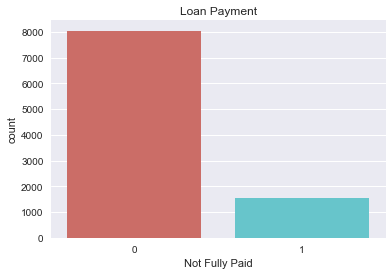

In [7]:
sns.countplot(x='not.fully.paid', data=loans, palette='hls')
plt.title('Loan Payment')
plt.xlabel('Not Fully Paid')

**What are the reasons people get loans, and how does that factor into the likelihood they are paid in full?**

+ Most loans are taken for debt consolidation or for credit cards
+ There seems to be a similar ratio for payment/non-payment for each purpose 

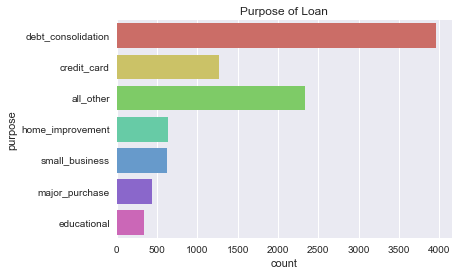

In [45]:
sns.countplot(y='purpose', data=loans, palette='hls')
plt.title('Purpose of Loan')

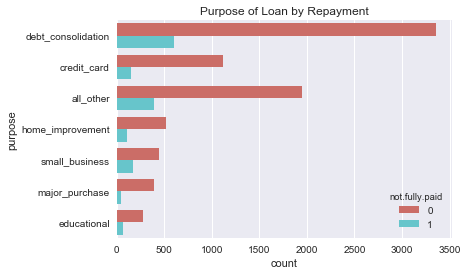

In [46]:
sns.countplot(y='purpose', data=loans, palette='hls', hue='not.fully.paid')
plt.title('Purpose of Loan by Repayment')

** How does the credit-worthiness compare with credit score?**
+ LendingClub policy approved loan recipients tend to have higher FICO scores
+ Unpaid loans show a similar distribution as FICO scores, although there are fewer unpaid loans

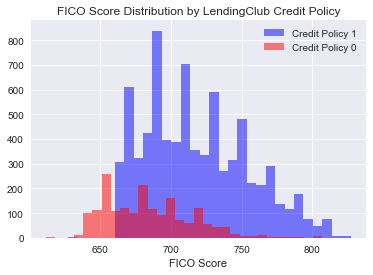

In [42]:
plt.figure()
loans[loans['credit.policy'] == 1]['fico'].hist(alpha=0.5, color='blue',
                                                bins=30, label='Credit Policy 1')
loans[loans['credit.policy'] == 0]['fico'].hist(alpha=0.5, color='red', 
                                                bins = 30, label='Credit Policy 0')
plt.legend()
plt.title('FICO Score Distribution by LendingClub Credit Policy')
plt.xlabel('FICO Score')

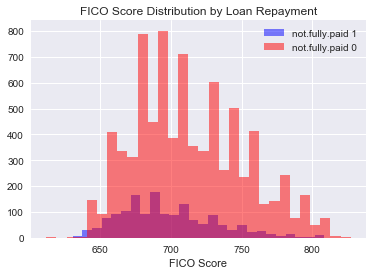

In [43]:
plt.figure()
loans[loans['not.fully.paid'] == 1]['fico'].hist(alpha=0.5, color='blue',
                                                bins=30, label='not.fully.paid 1')
loans[loans['not.fully.paid'] == 0]['fico'].hist(alpha=0.5, color='red', 
                                                bins = 30, label='not.fully.paid 0')
plt.legend()
plt.title('FICO Score Distribution by Loan Repayment')
plt.xlabel('FICO Score')

**Interest rate shows a decreasing trend as FICO score increases**

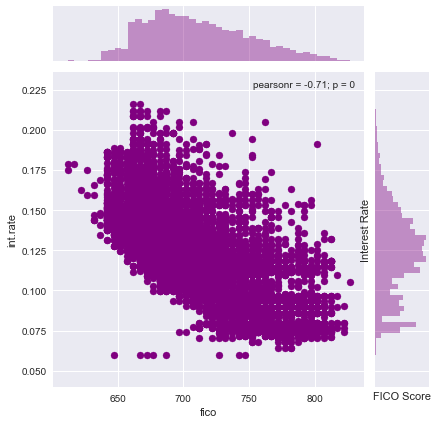

In [47]:
sns.jointplot(x='fico', y='int.rate', data=loans, color='purple', size=6)
plt.xlabel('FICO Score')
plt.ylabel('Interest Rate')

**The information above separated by repayment and credit policy**
+ Unapproved policies have lower FICO scores and higher interest rates
+ The relationship between Interest Rate and FICO Score, as well as the distribution of credit policy types, is similar between paid and unpaid accounts

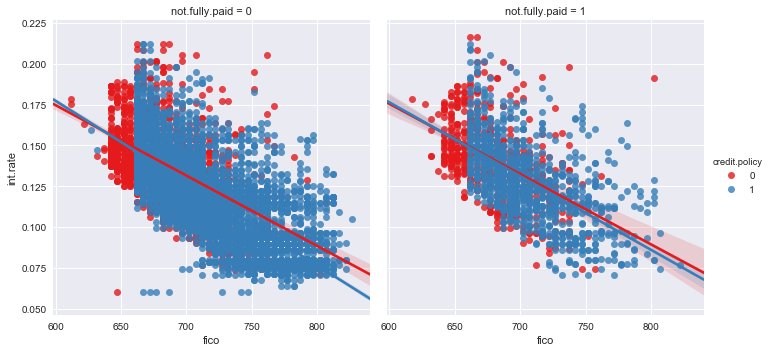

In [49]:
plt.figure(figsize=(11,7))
sns.lmplot(y='int.rate',x='fico',data=loans,hue='credit.policy',
           col='not.fully.paid',palette='Set1')

** Heatmap showing the correlation between variables**

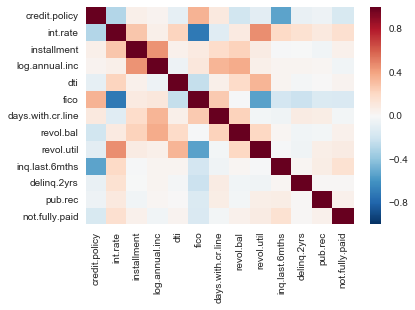

In [14]:
# check for independence between variables
sns.heatmap(loans.corr())

## Data preprocessing
+ Replace categorical variables with numerical dummies (ie. 'purpose')
+ Split the data into Training and Testing sets

In [50]:
# Replace categorical variables with numerical dummies 
cat_feats = ['purpose']
final_data = pd.get_dummies(loans,columns=cat_feats,drop_first=True)

In [51]:
final_data.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


In [59]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [52]:
X = final_data.drop('not.fully.paid', axis=1)
y = final_data['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=4)

## Decision Trees

In [53]:
from sklearn.tree import DecisionTreeClassifier

In [54]:
dtree = DecisionTreeClassifier()

In [55]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [56]:
predictions = dtree.predict(X_test)

In [57]:
from sklearn.metrics import classification_report,confusion_matrix

In [58]:
print('classification report')
print(classification_report(y_test, predictions))
print('confusion matrix')
print(confusion_matrix(y_test,predictions))

classification report
             precision    recall  f1-score   support

          0       0.86      0.84      0.85      2442
          1       0.21      0.25      0.23       432

avg / total       0.76      0.75      0.76      2874

confusion matrix
[[2042  400]
 [ 325  107]]


** 76% accuracy for Decision Trees out of the box -- let's check how well they actually work using KFold Cross-validation**

In [60]:
kfold = StratifiedKFold(n_splits=10)

In [96]:
def get_cross_val_score(X,y,classifier_to_test):
    scores = []
    for train_index, test_index in kfold.split(X,y):
        # Assign indices for training and testing sets
        xtrain, xtest = X.iloc[train_index], X.iloc[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        # Instantiate, fit, score classifier
        classifier = classifier_to_test
        classifier.fit(xtrain, ytrain)
        score = classifier.score(xtest, ytest)
        scores.append(score)
    return scores

In [99]:
scores = get_cross_val_score(X,y,DecisionTreeClassifier())

In [100]:
print('Mean accuracy for Decision Tree using stratified K-fold validation is {:0.2f}%'.format(np.mean(scores)*100))
print('With a standard deviation of {:0.2f}%'.format(np.std(scores)*100))

Mean accuracy for Decision Tree using stratified K-fold validation is 70.78%
With a standard deviation of 8.20%


** There appears to be a good amount of variance between cross-validation samples. Let's try another approach. **

## Random Forests

In [73]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
rfc = RandomForestClassifier()

In [75]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [76]:
y_pred = rfc.predict(X_test)

In [77]:
print('classification report')
print(classification_report(y_test, y_pred))
print('confusion matrix')
print(confusion_matrix(y_test,y_pred))

classification report
             precision    recall  f1-score   support

          0       0.85      0.98      0.91      2442
          1       0.35      0.05      0.09       432

avg / total       0.78      0.84      0.79      2874

confusion matrix
[[2402   40]
 [ 410   22]]


** 78% classification accuracy out of the box--but does it hold up with cross validation? **

In [101]:
scores = get_cross_val_score(X,y,RandomForestClassifier())

In [102]:
print('Mean accuracy for Random Forests using stratified K-fold validation is {:0.2f}%'.format(np.mean(scores)*100))
print('With a standard deviation of {:0.2f}%'.format(np.std(scores)*100))

Mean accuracy for Random Forests using stratified K-fold validation is 79.62%
With a standard deviation of 8.27%


** Random Forests perform better than Decision Trees (80% vs 71%), but with similar variance. **

** Now, can we improve the performance of Random Forest Classifiers by varying the number of estimators? **

In [80]:
def calibrate_rfc(X_train, X_test, y_train, y_test, estimators=10):
    scores = []
    est_vals = [i for i in range(10,estimators+1,10)]
    for i in range(len(est_vals)):
        rfc = RandomForestClassifier(n_estimators=est_vals[i])
        rfc.fit(X_train,y_train)
        scores.append(rfc.score(X_test,y_test))
    return est_vals, scores

In [81]:
estimator_values, rfc_scores = calibrate_rfc(X_train, X_test, y_train, y_test, estimators=100)

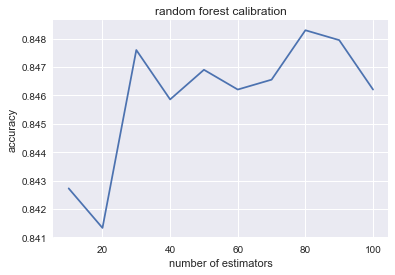

In [82]:
plt.plot(estimator_values,rfc_scores)
plt.title('random forest calibration')
plt.xlabel('number of estimators')
plt.ylabel('accuracy')

**Accuracy jumps above 84% for a number of estimators greater than 30%. Is it consistent?**

In [103]:
scores = get_cross_val_score(X,y,RandomForestClassifier(n_estimators=30))

In [104]:
print('Mean accuracy for Random Forests (30 estimators) using stratified K-fold validation is {:0.2f}%'.format(np.mean(scores)*100))
print('With a standard deviation of {:0.2f}%'.format(np.std(scores)*100))

Mean accuracy for Random Forests (30 estimators) using stratified K-fold validation is 79.46%
With a standard deviation of 9.08%


** Not really! Stick to 10 estimators. **

** At about 80% we're not doing too badly, but let's try another method...**

## K-Nearest Neighbors

In [86]:
# scale data for better performance in knn
from sklearn.preprocessing import StandardScaler

In [87]:
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [88]:
from sklearn.neighbors import KNeighborsClassifier

In [89]:
def calibrate_knn(X_train, X_test, y_train, y_test, k_min=1, k_max=10):
    scores = []
    k_vals = [i for i in range(k_min,k_max+1)]
    for i in range(len(k_vals)):
        knn = KNeighborsClassifier(n_neighbors=k_vals[i])
        knn.fit(X_train,y_train)
        scores.append(knn.score(X_test,y_test))
    return k_vals, scores

In [90]:
k_values, k_scores = calibrate_knn(X_train_std, X_test_std, y_train, y_test, k_min=1, k_max=50)

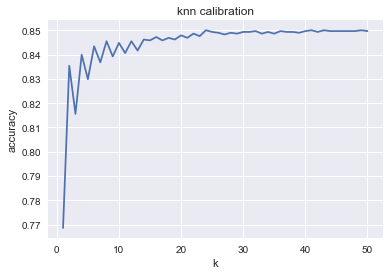

In [91]:
plt.plot(k_values,k_scores)
plt.title('knn calibration')
plt.xlabel('k')
plt.ylabel('accuracy')

**Around ~k=30, accuracy stabilizes at 85%, but let's check its consistency with K-Fold validation **

In [105]:
scores = get_cross_val_score(X,y,KNeighborsClassifier(n_neighbors=30))

In [106]:
print('Mean accuracy for K-30 nearest neighbors using stratified K-fold validation is {:0.2f}%'.format(np.mean(scores)*100))
print('With a standard deviation of {:0.2f}%'.format(np.std(scores)*100))

Mean accuracy for K-nearest neighbors using stratified K-fold validation is 83.37%
With a standard deviation of 1.25%


** 83% accuracy with very low variance (1.25% standard deviation) -- Not bad at all! **

** So far, KNN performs better on average across 10 cross-validation sets than Decision Trees and Random Forests. Additionally, there is little variation between performance on each set. **

** How about scaled data for KNN with 30 neighbors? **

In [108]:
X_scaled = StandardScaler().fit_transform(X) # Transform entire X set
X_scaled_df = pd.DataFrame(X_scaled) # convert to pandas dataframe, current function requires it

In [112]:
scores = get_cross_val_score(X_scaled_df,y,KNeighborsClassifier(n_neighbors=30))

In [114]:
print('Mean accuracy for K-30 nearest neighbors with scaling using K-fold validation is {:0.2f}%'.format(np.mean(scores)*100))
print('With a standard deviation of {:0.2f}%'.format(np.std(scores)*100))

Mean accuracy for K-30 nearest neighbors with scaling using K-fold validation is 83.27%
With a standard deviation of 1.66%


** About the same! **

** How about a simpler approach with Logistic Regression? **

In [115]:
from sklearn.linear_model import LogisticRegression

In [116]:
scores = get_cross_val_score(X,y,LogisticRegression())

In [119]:
print('Mean accuracy for Logistic Regression using Stratified K-fold validation is {:0.2f}%'.format(np.mean(scores)*100))
print('With a standard deviation of {:0.2f}%'.format(np.std(scores)*100))

Mean accuracy for Logistic Regression using Stratified K-fold validation is 83.66%
With a standard deviation of 0.80%


** Pretty, pretty, pretty good! **

## Conclusions

+ This is a pretty clean data set
+ There are no missing values, no NaN values, and only one categorical variable
+ Simpler methods, such as KNN and Logistic Regression performed better on average than Decision Trees and Random Forests
+ This may not necessarily be true for other datasets, where things aren't as neat to begin with